In [2]:
import polars as pl

In [3]:
df = (
    pl.read_csv(
        "./data/events.csv",
        # schema={"timestamp": pl.Int64, "visitorid": pl.Int64, "itemid": pl.Int64, "transactionid": pl.String},
    )
    .lazy()
    .with_columns(pl.from_epoch("timestamp", time_unit="ms"))
    .drop(["transactionid"])
)

In [65]:
n_events_bigger_10 = (
    df.group_by("visitorid")
    .agg(
        pl.col("itemid").count().alias("n_events"),
    )
    .filter(pl.col("n_events") > 10)
)

In [66]:
events_reduced = df.join(n_events_bigger_10, on='visitorid', how='inner')

In [82]:
events_reduced.with_columns(
    lagged=pl.col("timestamp")
    .shift(1)
    .over(pl.col("visitorid"), order_by=pl.col("timestamp"))
).with_columns(time_diff=pl.col("timestamp") - pl.col("lagged")).with_columns(
    time_diff_mins=pl.col("time_diff").dt.total_minutes()
).filter(
    pl.col("visitorid") == 992329
)

ModuleUpgradeRequiredError: altair>=5.4.0 is required for `.plot`

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
small_world_graph = nx.watts_strogatz_graph(50, 10, 0.1)
clustering_coeff = nx.average_clustering(small_world_graph)
print(clustering_coeff)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Small World Graph")
nx.draw(small_world_graph, ax=ax)
plt.show()

In [ ]:
# ... existing code ...

# Try these parameters for high clustering
high_clustering_graph = nx.watts_strogatz_graph(
    50, 10, 0.01
)  # increased k, decreased p
pos = nx.spectral_layout(high_clustering_graph)
clustering_coeff = nx.average_clustering(high_clustering_graph)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.set_title(f"High Clustering Graph\nClustering Coefficient: {clustering_coeff:.3f}")
nx.draw(high_clustering_graph, ax=ax1, pos=pos)

# Compare with original parameters
original_graph = nx.watts_strogatz_graph(50, 8, 0.2)
original_clustering = nx.average_clustering(original_graph)

ax2.set_title(f"Original Graph\nClustering Coefficient: {original_clustering:.3f}")
nx.draw(original_graph, ax=ax2)

plt.show()

In [14]:
group_means = [200,500,125]
stdev = 50

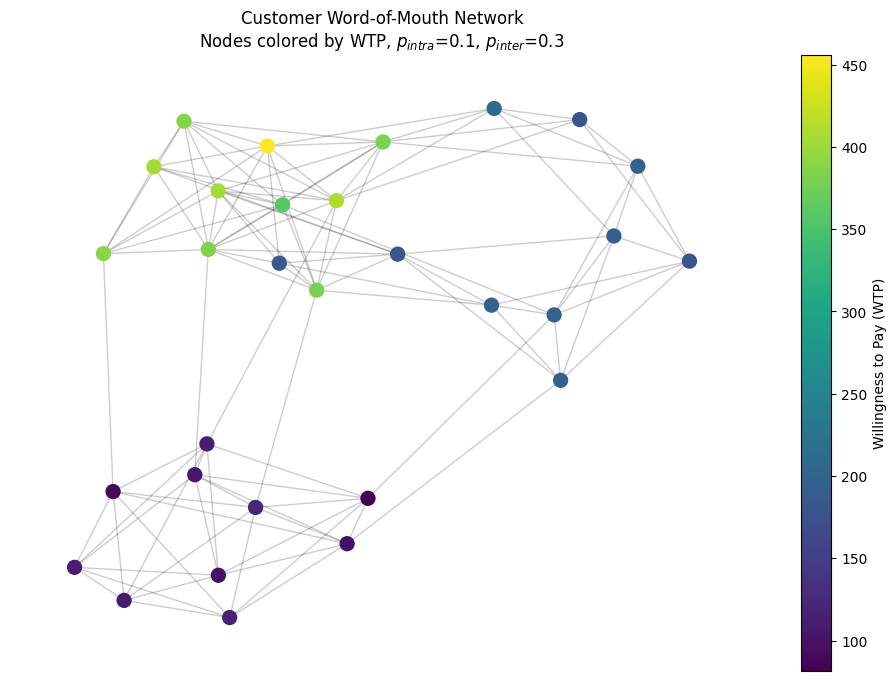

In [24]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


def generate_customer_network(G, N_per_group:list, K, p_intra, p_inter, mu_wtp, sigma_wtp):
    """
    Generates a clustered small-world network for word-of-mouth effects in e-commerce.

    Parameters:
        G (int): Number of customer groups.
        N_per_group (int): Number of customers per group.
        K (int): Mean degree for intra-group connections.
        p_intra (float): Rewiring probability within each group.
        p_inter (float): Probability of inter-group connections.
        mu_wtp (list): List of mean WTP values for each group.
        sigma_wtp (float): Standard deviation for WTP.

    Returns:
        G (networkx.Graph): The generated customer network.
        WTP (dict): Dictionary mapping nodes to their WTP values.
    """
    total_nodes = G * N_per_group
    network = nx.Graph()
    WTP = {}

    # Create groups with intra-group connections
    for group in range(G):
        nodes = list(range(group * N_per_group[group], (group + 1) * N_per_group[group]))
        # Assign WTP values from normal distribution
        wtp_values = np.random.normal(mu_wtp[group], sigma_wtp, N_per_group[group])
        WTP.update(dict(zip(nodes, wtp_values)))

        # Create a small-world network within the group
        subgraph = nx.watts_strogatz_graph(N_per_group[group], K, p_intra)

        # Relabel nodes to match global numbering
        mapping = {i: nodes[i] for i in range(N_per_group[group])}
        subgraph = nx.relabel_nodes(subgraph, mapping)

        network.add_edges_from(subgraph.edges())

    # Add inter-group edges
    for group in range(G):
        nodes_A = list(range(group * N_per_group[group], (group + 1) * N_per_group[group]))
        for other_group in range(group + 1, G):
            nodes_B = list(
                range(other_group * N_per_group[other_group], (other_group + 1) * N_per_group[other_group])
            )

            for node in nodes_A:
                if np.random.rand() < p_inter:
                    target = np.random.choice(nodes_B)
                    network.add_edge(node, target)

    return network, WTP


# Example usage
G = 3  # Number of groups
N_per_group = [10,20,10]  # Customers per group
K = 6  # Each node connects to K neighbors
p_intra = 0.1  # Low probability of rewiring within group
p_inter = 0.3  # Small chance of inter-group connections
mu_wtp = [100, 200, 400]  # Mean WTP for each group
sigma_wtp = 20  # Standard deviation of WTP

customer_network, WTP = generate_customer_network(
    G, N_per_group, K, p_intra, p_inter, mu_wtp, sigma_wtp
)

# Plot the network with WTP-based coloring
plt.figure(figsize=(12, 8))

# Convert WTP dictionary to a list of values in node order
wtp_values = [WTP[node] for node in customer_network.nodes()]

# Create a scatter plot of the network
pos = nx.spring_layout(customer_network)  # Calculate layout once
nodes = nx.draw_networkx_nodes(
    customer_network,
    pos,
    node_color=wtp_values,
    node_size=100,
    cmap=plt.cm.viridis,  # You can change the colormap
)
edges = nx.draw_networkx_edges(customer_network, pos, alpha=0.2)

# Add a colorbar
plt.colorbar(nodes, label="Willingness to Pay (WTP)")

plt.title(
    "Customer Word-of-Mouth Network\nNodes colored by WTP, $p_{intra}$=" + str(p_intra) + ", $p_{inter}$=" + str(p_inter)
)
plt.axis("off")
plt.show()

In [45]:
N_per_group = [10, 20, 30]
mu_wtp = [500, 150, 200]
G = 3
sigma_wtp = 20

nodes = [i for i in range(sum(N_per_group))]
means = np.array([])

for g in range(G):
    means = np.append(means, np.random.normal(mu_wtp[g], sigma_wtp, N_per_group[g]))



In [ ]:
import seaborn as sns

abs_diff = np.abs(means.reshape(-1,1) - means.reshape(1,-1))

sns.heatmap(abs_diff/abs_diff.max())

<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_26530/2709986630.py:30: SyntaxWarning: invalid escape sequence '\l'
  label=r"Prospect Theory Value Function ($\alpha=" + str(alpha) + "$, $\lambda=1/2.25$)",
/tmp/ipykernel_26530/2709986630.py:37: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel("$\Delta WTP_{i,w}$", fontsize=12)


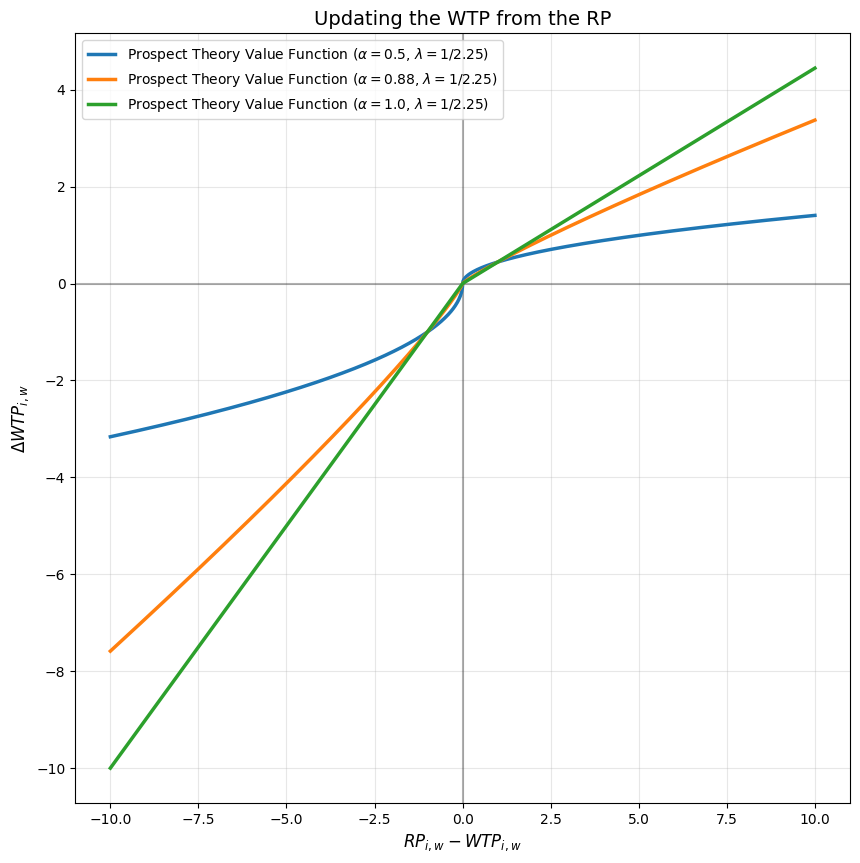

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def prospect_theory_value(x, alpha=0.88, lambda_=2.25):
    """Calculate the subjective value according to Prospect Theory's value function."""
    result = np.zeros_like(x, dtype=float)
    
    # For gains (x >= 0)
    gains_idx = x >= 0
    result[gains_idx] = 1/lambda_ * x[gains_idx] ** alpha
    
    # For losses (x < 0)
    losses_idx = x < 0
    result[losses_idx] =  -((-x[losses_idx]) ** alpha)
    
    return result

fig, ax = plt.subplots(figsize=(10, 10))
ax.axhline(y=0, color="k", linestyle="-", alpha=0.3)
ax.axvline(x=0, color="k", linestyle="-", alpha=0.3)

for alpha in [0.5, 0.88, 1.0]:
    x = np.linspace(-10, 10, 1000)
    y = prospect_theory_value(x, alpha=alpha)

    ax.plot(
        x,
        y,
        linewidth=2.5,
        label=r"Prospect Theory Value Function ($\alpha=" + str(alpha) + "$, $\lambda=1/2.25$)",
    )
    ax.grid(True, alpha=0.3)
    

ax.set_title("Updating the WTP from the RP", fontsize=14)
ax.set_xlabel("$RP_{i,w}-WTP_{i,w}$", fontsize=12)
ax.set_ylabel("$\Delta WTP_{i,w}$", fontsize=12)
ax.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
# Create data - now using percentage differences
price_diff_pct = np.linspace(-1, 1, 1000)  # -100% to +100%
scales = [5, 10, 20, 50]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

for scale in scales:
    # Calculate purchase probability
    prob = 1 / (1 + np.exp(-(price_diff_pct * scale)))
    ax.plot(price_diff_pct * 100, prob, label=f"Scale = {scale}")

# Customize plot
ax.axvline(x=0, color="gray", linestyle="--", alpha=0.5)
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
# ax.grid(True, alpha=0.3)
ax.set_xlabel("(WTP - Price) / WTP [%]")
ax.set_ylabel("Purchase Probability")
ax.set_title(
    "Purchase Probability vs Price Difference Percentage\nfor Different Scale Factors"
)
ax.legend()
ax.grid(True, alpha=0.3)
# Add annotations
ax.text(5, 0.45, "WTP = Price\n(50% probability)", verticalalignment="top")

plt.tight_layout()
plt.show()